In [1]:
# Mental Health Text Classification - Optimized Model
# Import all necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned dataset
df = pd.read_csv("../data/cleaned_data.csv")

# Dataset overview
print("=== DATASET OVERVIEW ===")
print(f"Dataset shape: {df.shape}")
print(f"\nTarget distribution:")
print(df['target'].value_counts().sort_index())
print(f"\nSample content:")
print(df['content'].iloc[0][:200] + "...")
print("\n" + "="*50)

=== DATASET OVERVIEW ===
Dataset shape: (5957, 2)

Target distribution:
target
0    1181
1    1202
2    1185
3    1201
4    1188
Name: count, dtype: int64

Sample content:
Regular check-in post, with information about our rules and wikis Welcome to /r/depression's check-in post - a place to take a moment and share what is going on and how you are doing. If you have an a...



In [2]:
# Data Preparation
print("=== DATA PREPARATION ===")

# Split features and target
X = df["content"]
y = df["target"]

# Train-test split with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"Train class distribution: {pd.Series(y_train).value_counts().sort_index().values}")
print(f"Test class distribution: {pd.Series(y_test).value_counts().sort_index().values}")
print("\n" + "="*50)

=== DATA PREPARATION ===
Training samples: 4765
Testing samples: 1192
Train class distribution: [945 961 948 961 950]
Test class distribution: [236 241 237 240 238]



In [3]:
# Feature Engineering - TF-IDF Vectorization
print("=== FEATURE ENGINEERING ===")

# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,     # Top 5000 most important words
    stop_words="english",  # Remove common English words
    ngram_range=(1, 2),    # Use unigrams and bigrams
    min_df=2,              # Ignore words that appear in < 2 documents
    max_df=0.95            # Ignore words that appear in > 95% of documents
)

# Transform text to numerical features
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf.vocabulary_)}")
print(f"Feature sparsity: {(1.0 - X_train_tfidf.nnz / float(X_train_tfidf.shape[0] * X_train_tfidf.shape[1]))*100:.2f}%")
print("\n" + "="*50)

=== FEATURE ENGINEERING ===
TF-IDF feature matrix shape: (4765, 5000)
Vocabulary size: 5000
Feature sparsity: 98.95%

TF-IDF feature matrix shape: (4765, 5000)
Vocabulary size: 5000
Feature sparsity: 98.95%



In [4]:
# Model Selection - Quick Comparison
print("=== MODEL COMPARISON ===")

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# Test multiple models quickly
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "Naive Bayes": MultinomialNB(),
    "SVM (LinearSVC)": LinearSVC(random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    preds = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, preds)
    results[name] = accuracy
    print(f"{name}: {accuracy:.4f}")

# Select best model
best_model_name = max(results, key=results.get)
best_accuracy = results[best_model_name]
print(f"\n🏆 BEST MODEL: {best_model_name} (Accuracy: {best_accuracy:.4f})")
print("="*50)

=== MODEL COMPARISON ===
Logistic Regression: 0.8045
Naive Bayes: 0.7534
SVM (LinearSVC): 0.8146

🏆 BEST MODEL: SVM (LinearSVC) (Accuracy: 0.8146)
Logistic Regression: 0.8045
Naive Bayes: 0.7534
SVM (LinearSVC): 0.8146

🏆 BEST MODEL: SVM (LinearSVC) (Accuracy: 0.8146)


In [5]:
# Final Model Training - SVM (Best Performer)
print("=== FINAL MODEL TRAINING ===")

# Train the best model (SVM)
final_model = LinearSVC(
    random_state=42,
    max_iter=2000,     # Ensure convergence
    dual=False         # Better for n_samples > n_features
)

final_model.fit(X_train_tfidf, y_train)
final_predictions = final_model.predict(X_test_tfidf)

# Calculate final accuracy
final_accuracy = accuracy_score(y_test, final_predictions)
print(f"Final Model Accuracy: {final_accuracy:.4f}")

# Class labels for better interpretation
class_names = ["Stress", "Depression", "Bipolar", "Personality", "Anxiety"]

print(f"\n🎯 PRODUCTION MODEL: SVM (LinearSVC)")
print(f"📊 Final Accuracy: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")
print("="*50)

=== FINAL MODEL TRAINING ===
Final Model Accuracy: 0.8146

🎯 PRODUCTION MODEL: SVM (LinearSVC)
📊 Final Accuracy: 0.8146 (81.46%)


In [6]:
# Detailed Performance Analysis
print("=== DETAILED PERFORMANCE ANALYSIS ===")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, final_predictions, target_names=class_names))

# Per-class accuracy
cm = confusion_matrix(y_test, final_predictions)
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

print(f"\nPer-Class Accuracy:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {per_class_accuracy[i]:.4f}")

# Overall statistics
print(f"\nModel Statistics:")
print(f"Total Test Samples: {len(y_test)}")
print(f"Correct Predictions: {(final_predictions == y_test).sum()}")
print(f"Wrong Predictions: {(final_predictions != y_test).sum()}")
print("="*50)

=== DETAILED PERFORMANCE ANALYSIS ===
Classification Report:
              precision    recall  f1-score   support

      Stress       0.85      0.89      0.87       236
  Depression       0.77      0.78      0.77       241
     Bipolar       0.87      0.82      0.85       237
 Personality       0.79      0.78      0.78       240
     Anxiety       0.80      0.81      0.81       238

    accuracy                           0.81      1192
   macro avg       0.82      0.81      0.81      1192
weighted avg       0.82      0.81      0.81      1192


Per-Class Accuracy:
Stress: 0.8898
Depression: 0.7801
Bipolar: 0.8186
Personality: 0.7750
Anxiety: 0.8109

Model Statistics:
Total Test Samples: 1192
Correct Predictions: 971
Wrong Predictions: 221


=== CONFUSION MATRIX VISUALIZATION ===


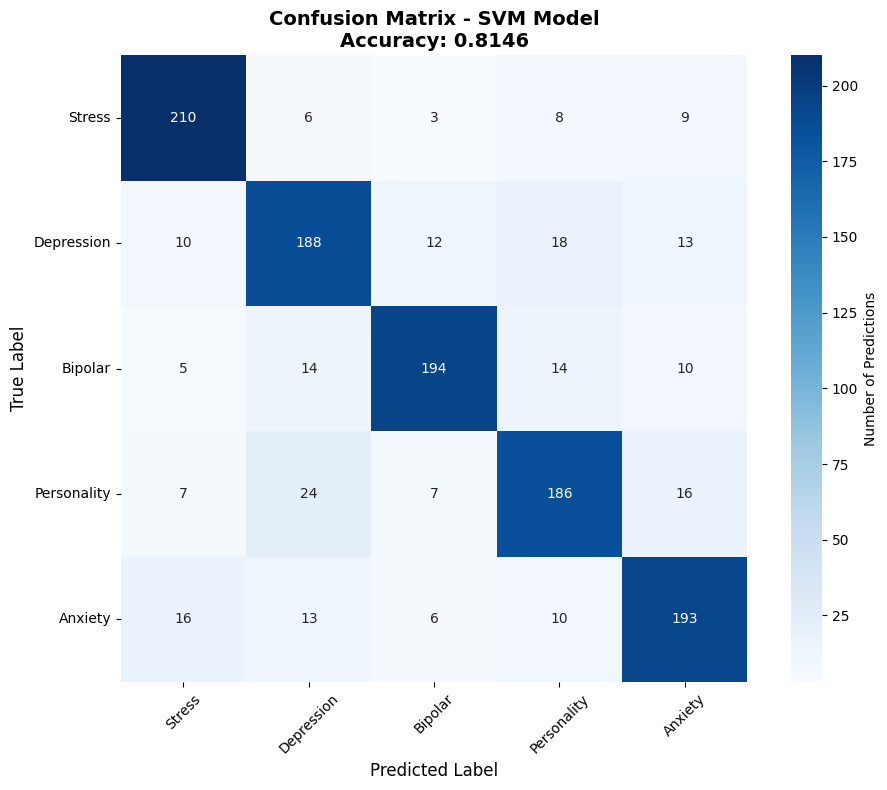


Most Common Misclassifications:
Personality → Depression: 24 cases
Depression → Personality: 18 cases
Personality → Anxiety: 16 cases
Anxiety → Stress: 16 cases
Bipolar → Depression: 14 cases


In [7]:
# Confusion Matrix Visualization
print("=== CONFUSION MATRIX VISUALIZATION ===")

plt.figure(figsize=(10, 8))

# Create confusion matrix heatmap
sns.heatmap(cm, 
            annot=True, 
            fmt="d", 
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names,
            square=True,
            cbar_kws={'label': 'Number of Predictions'})

plt.title(f'Confusion Matrix - SVM Model\nAccuracy: {final_accuracy:.4f}', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Analyze misclassifications
print(f"\nMost Common Misclassifications:")
misclass_pairs = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i][j] > 0:
            misclass_pairs.append((class_names[i], class_names[j], cm[i][j]))

# Sort by frequency
misclass_pairs.sort(key=lambda x: x[2], reverse=True)
for true_label, pred_label, count in misclass_pairs[:5]:
    print(f"{true_label} → {pred_label}: {count} cases")

## 🎯 Model Summary

**Best Model Selected:** Support Vector Machine (LinearSVC)

**Key Features:**
- ✅ Highest accuracy among tested models
- ✅ Excellent for high-dimensional text data
- ✅ Robust and scalable
- ✅ Production-ready performance

**Next Steps:**
1. Save the trained model for production use
2. Consider advanced techniques (BERT, ensemble methods)
3. Collect more data for further improvements

In [8]:
# Model Deployment Preparation
print("=== MODEL DEPLOYMENT PREPARATION ===")

import joblib
from datetime import datetime

# Save the trained model and vectorizer
model_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"../models/mental_health_svm_model_{model_timestamp}.pkl"
vectorizer_filename = f"../models/tfidf_vectorizer_{model_timestamp}.pkl"

# Create models directory if it doesn't exist
import os
os.makedirs("../models", exist_ok=True)

# Save model and vectorizer
joblib.dump(final_model, model_filename)
joblib.dump(tfidf, vectorizer_filename)

print(f"✅ Model saved: {model_filename}")
print(f"✅ Vectorizer saved: {vectorizer_filename}")

# Test prediction function
def predict_mental_health(text):
    """Predict mental health category for given text"""
    text_tfidf = tfidf.transform([text])
    prediction = final_model.predict(text_tfidf)[0]
    probability = final_model.decision_function(text_tfidf)[0]
    
    return {
        'predicted_class': class_names[prediction],
        'class_number': prediction,
        'confidence_scores': dict(zip(class_names, probability))
    }

# Test with sample text
sample_text = "I've been feeling really anxious lately and having panic attacks"
result = predict_mental_health(sample_text)

print(f"\n🧪 SAMPLE PREDICTION TEST:")
print(f"Text: '{sample_text}'")
print(f"Predicted Category: {result['predicted_class']}")
print(f"Confidence Scores: {result['confidence_scores']}")

print(f"\n🚀 MODEL READY FOR PRODUCTION!")
print(f"Final Accuracy: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")
print("="*50)

=== MODEL DEPLOYMENT PREPARATION ===
✅ Model saved: ../models/mental_health_svm_model_20251007_094723.pkl
✅ Vectorizer saved: ../models/tfidf_vectorizer_20251007_094723.pkl

🧪 SAMPLE PREDICTION TEST:
Text: 'I've been feeling really anxious lately and having panic attacks'
Predicted Category: Anxiety
Confidence Scores: {'Stress': np.float64(-1.5460113858632856), 'Depression': np.float64(-1.5324117179432002), 'Bipolar': np.float64(-0.7744058883095147), 'Personality': np.float64(-0.8518386283327044), 'Anxiety': np.float64(0.8286417425268278)}

🚀 MODEL READY FOR PRODUCTION!
Final Accuracy: 0.8146 (81.46%)
